In [367]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, norm, gamma, t, laplace, logistic, chi2, lognorm 
from scipy import stats
import time
import warnings
import os

In [368]:
from src.estimators.semiparametric.nm_semiparametric_estimator import NMSemiParametricEstimator
from src.generators.nm_generator import NMGenerator
from src.mixtures.nm_mixture import NormalMeanMixtures

M_SIMULATIONS = 100      
N_SAMPLES_LIST = [2000] 
SIGMA_0_VALUES = [0.5, 1.0, 5.0, 10.0]
SEARCH_AREA = 15.0

DISTRIBUTIONS_TO_TEST = {
    "Normal(0,1)": norm(loc=0, scale=1),
    #"Gamma(2,2)": gamma(a=2, scale=1),
    "Mixture 0.5N(-3,1)+0.5N(3,1)": "mixture",
    "Expon": expon,
    #"t": t(df=5, loc=0, scale=2),
    "Laplace": laplace(loc=0, scale=1),
    #"logistics": logistic(loc=0, scale=1),
    #"chi": chi2(df=5),
    #"lognorm": lognorm(s=0.8, loc=0, scale=np.exp(0))
}

A_PARAM = 1/8
B_PARAM = 1/16

ALPHA_PARAM_EMPIRICAL = 0.9

OUTPUT_DIR = "validation_sigma_plots"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [372]:
def generate_nmm_sample(sigma_0, sample_len, mixing_dist_info):
    generator = NMGenerator()
    xi_sample = None

    if mixing_dist_info == "mixture":
        n_half = sample_len // 2
        xi_sample = np.concatenate([
            norm.rvs(loc=-3, scale=1, size=n_half),
            norm.rvs(loc=3, scale=1, size=sample_len - n_half)
        ])
        Z_sample = norm.rvs(loc=0, scale=1, size=sample_len)
        Y_sample = xi_sample + sigma_0 * Z_sample
        return Y_sample

    else:
        mixture = NormalMeanMixtures("canonical", sigma=sigma_0, distribution=mixing_dist_info)
        sample = generator.canonical_generate(mixture, sample_len)
        return sample

In [373]:
def estimate_sigma_matrix(sample, sample_len, search_area, a, b):

    log_n = math.log(sample_len)

    k = sample_len ** (1 / 2 - a - b)


    sqrt_log_n_term = math.sqrt(a * log_n / 2)
    l = (1 / search_area) * sqrt_log_n_term * k
    
    log_log_n = math.log(log_n)
    #eps_numerator_part = sqrt_log_n_term * k
    denominator_part = max(sample_len**b, 1.1)
    eps = ((math.sqrt(2 * a) / search_area) * (math.sqrt(log_n) / log_log_n)) / denominator_part



    estimator = NMSemiParametricEstimator(
        "sigma_estimation_eigenvalue_based",
        {"k": k, "l": l, "eps": eps, "search_area": search_area, "search_density": 100}
    )
    est = estimator.estimate(sample)

    value = est.value.real

    return value, k, l, eps


def estimate_sigma_empirical(sample, sample_len, search_area, alpha_param):
        log_n = math.log(sample_len)
        t_param_numerator = math.sqrt(alpha_param * log_n)
        t_param = t_param_numerator / (2 * search_area)

        estimator = NMSemiParametricEstimator("sigma_estimation_empirical", {"t": t_param})
        est = estimator.estimate(sample)
        value = est.value.real

        return value, t_param



In [374]:
all_results = {dist_name: {n: {s: {'matrix': [], 'empirical': []} for s in SIGMA_0_VALUES}
                          for n in N_SAMPLES_LIST}
               for dist_name in DISTRIBUTIONS_TO_TEST}

overall_start_time = time.time()

for dist_name, dist_info in DISTRIBUTIONS_TO_TEST.items():
    print(f"\n Distribution: {dist_name}")
    for n_samples in N_SAMPLES_LIST:
        print(f"\n n = {n_samples}")
        for sigma_0 in SIGMA_0_VALUES:
            print(f" sigma_0 = {sigma_0}")
            estimates_matrix_run = []
            estimates_empirical_run = []
            simulation_start_time = time.time()
            print(f"    Dist={dist_name}, n={n_samples}, sigma_0={sigma_0}")
            for i in range(M_SIMULATIONS):
                

                sample = generate_nmm_sample(sigma_0, n_samples, dist_info)
                sigma_hat_matrix, k_used, l_used, eps_used = estimate_sigma_matrix(sample, n_samples, SEARCH_AREA, A_PARAM, B_PARAM)
                estimates_matrix_run.append(sigma_hat_matrix)

                sigma_hat_empirical, t_used = estimate_sigma_empirical(sample, n_samples, SEARCH_AREA, ALPHA_PARAM_EMPIRICAL)
                estimates_empirical_run.append(sigma_hat_empirical)

            simulation_end_time = time.time()
            num_valid_matrix = len(estimates_matrix_run)
            num_valid_empirical = len(estimates_empirical_run)

            all_results[dist_name][n_samples][sigma_0]['matrix'].extend(estimates_matrix_run)
            all_results[dist_name][n_samples][sigma_0]['empirical'].extend(estimates_empirical_run)



 Distribution: Normal(0,1)

 n = 2000
 sigma_0 = 0.5
    Dist=Normal(0,1), n=2000, sigma_0=0.5
 sigma_0 = 1.0
    Dist=Normal(0,1), n=2000, sigma_0=1.0
 sigma_0 = 5.0
    Dist=Normal(0,1), n=2000, sigma_0=5.0
 sigma_0 = 10.0
    Dist=Normal(0,1), n=2000, sigma_0=10.0

 Distribution: Mixture 0.5N(-3,1)+0.5N(3,1)

 n = 2000
 sigma_0 = 0.5
    Dist=Mixture 0.5N(-3,1)+0.5N(3,1), n=2000, sigma_0=0.5
 sigma_0 = 1.0
    Dist=Mixture 0.5N(-3,1)+0.5N(3,1), n=2000, sigma_0=1.0
 sigma_0 = 5.0
    Dist=Mixture 0.5N(-3,1)+0.5N(3,1), n=2000, sigma_0=5.0
 sigma_0 = 10.0
    Dist=Mixture 0.5N(-3,1)+0.5N(3,1), n=2000, sigma_0=10.0

 Distribution: Expon

 n = 2000
 sigma_0 = 0.5
    Dist=Expon, n=2000, sigma_0=0.5
 sigma_0 = 1.0
    Dist=Expon, n=2000, sigma_0=1.0
 sigma_0 = 5.0
    Dist=Expon, n=2000, sigma_0=5.0
 sigma_0 = 10.0
    Dist=Expon, n=2000, sigma_0=10.0

 Distribution: Laplace

 n = 2000
 sigma_0 = 0.5
    Dist=Laplace, n=2000, sigma_0=0.5
 sigma_0 = 1.0
    Dist=Laplace, n=2000, sigma_0=1

Saved box plot: sigma_boxplot_Normal0,1_n2000.png


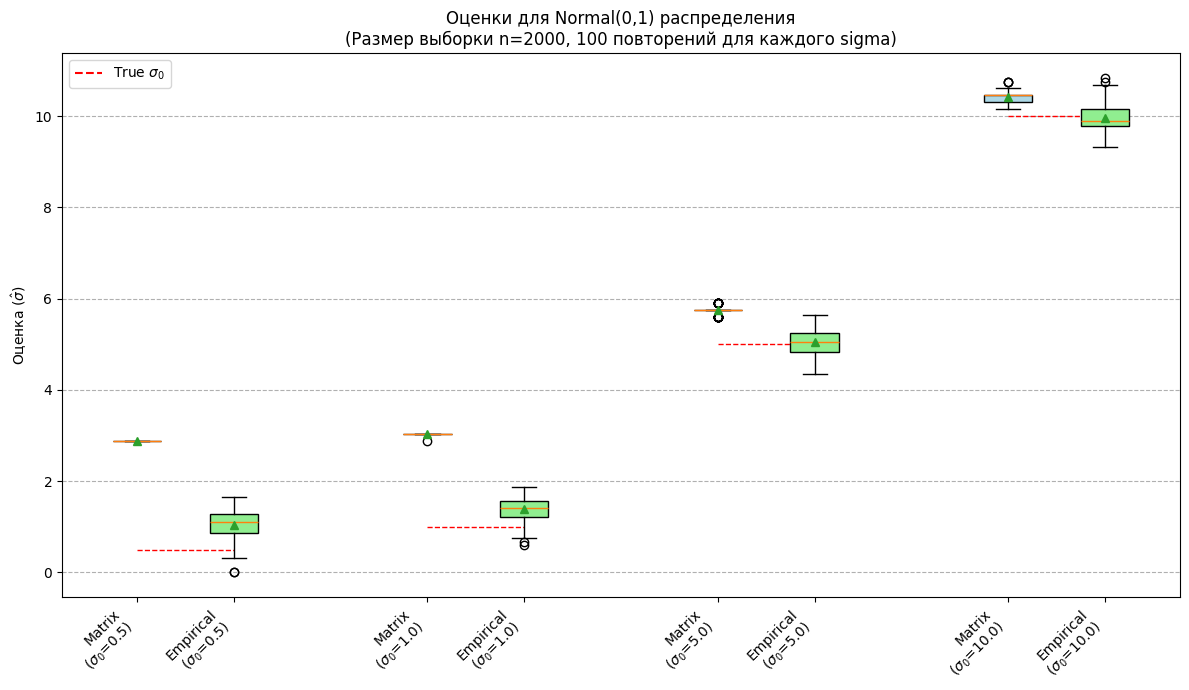

Saved box plot: sigma_boxplot_Mixture 05N-3,1+05N3,1_n2000.png


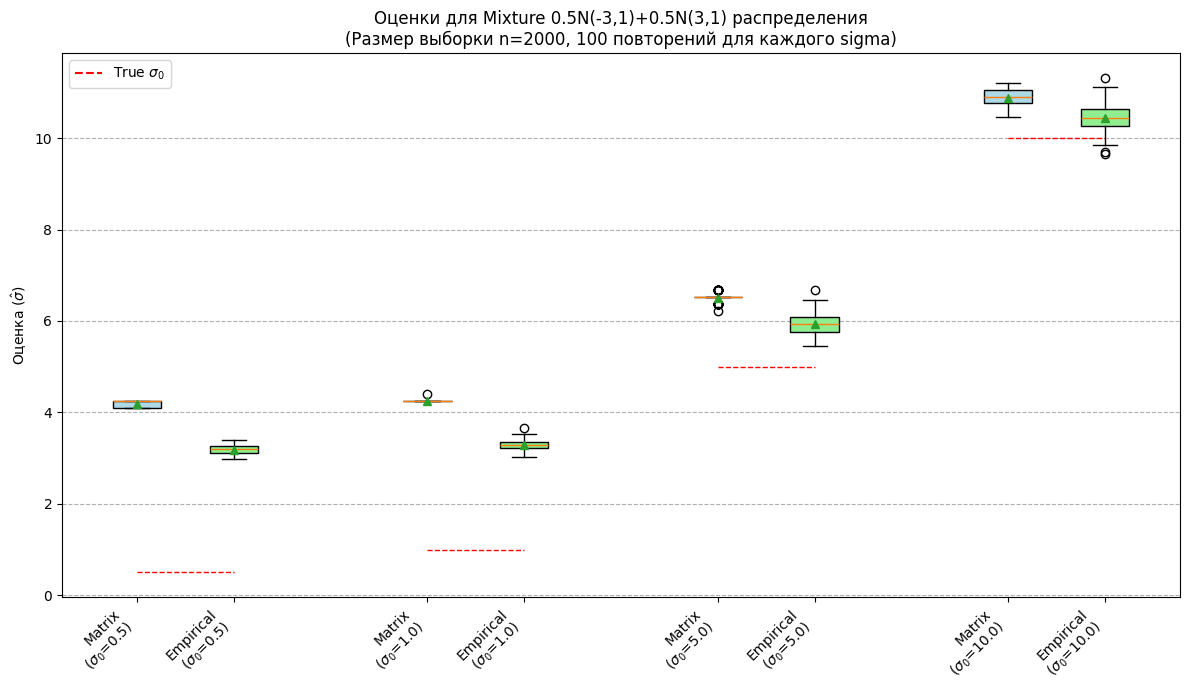

Saved box plot: sigma_boxplot_Expon_n2000.png


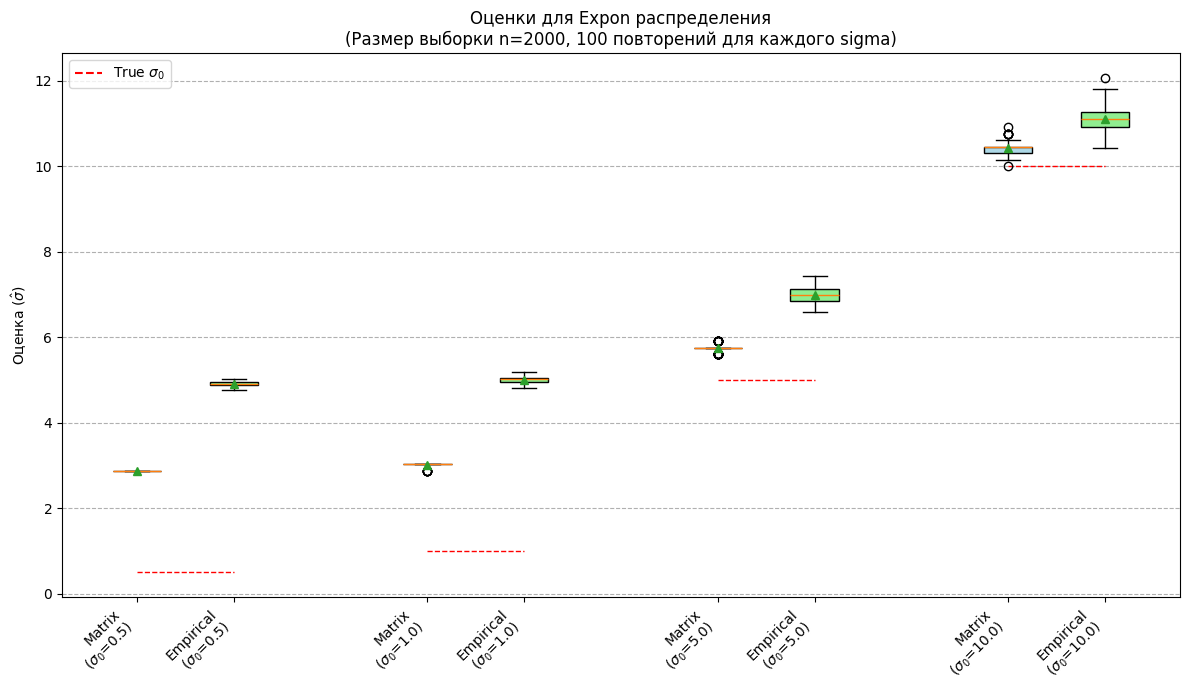

Saved box plot: sigma_boxplot_Laplace_n2000.png


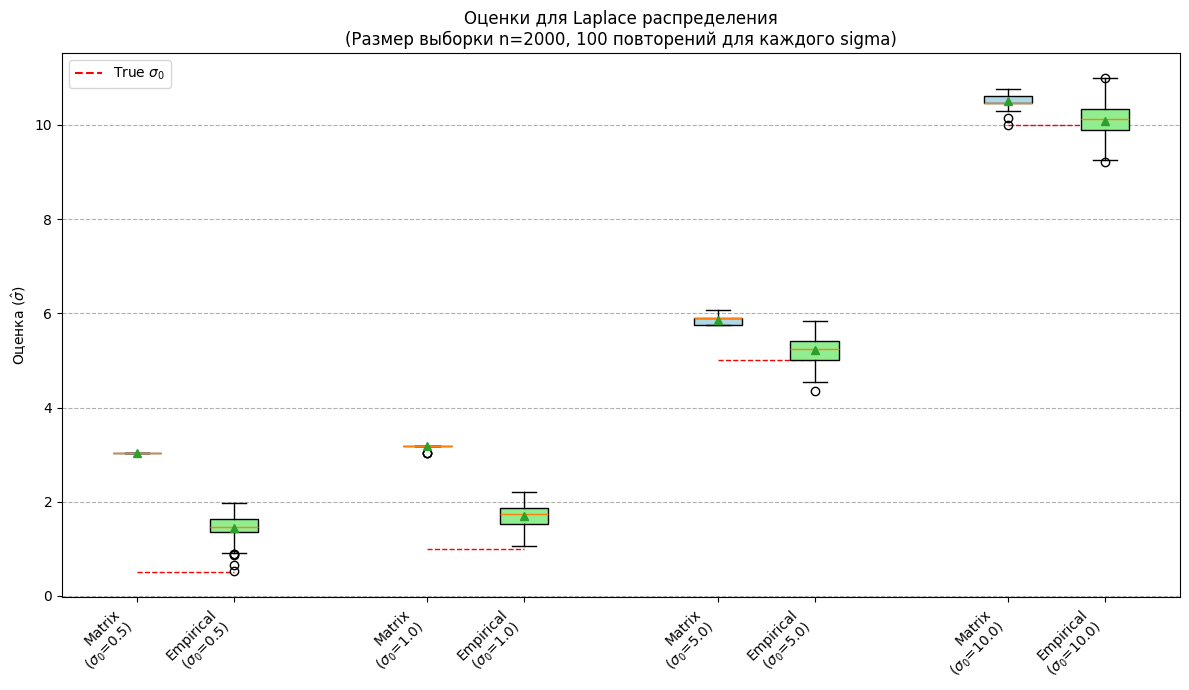

In [375]:
for dist_name in DISTRIBUTIONS_TO_TEST.keys():
    for n_samples in N_SAMPLES_LIST:
        fig, ax = plt.subplots(figsize=(12, 7))

        plot_data = []
        plot_labels = []
        positions = []
        current_pos = 1

        for sigma_0 in SIGMA_0_VALUES:
            estimates_m = all_results[dist_name][n_samples][sigma_0]['matrix']
            estimates_e = all_results[dist_name][n_samples][sigma_0]['empirical']

            plot_data.append(estimates_m)
            plot_labels.append(f'Matrix\n($\\sigma_0$={sigma_0})')
            positions.append(current_pos)
            current_pos += 1


            plot_data.append(estimates_e)
            plot_labels.append(f'Empirical\n($\\sigma_0$={sigma_0})')
            positions.append(current_pos)
            current_pos += 1


            line_pos = positions[-2] + 0.5 if len(positions) >= 2 else positions[-1]
            ax.plot([line_pos - 0.5, line_pos + 0.5], [sigma_0, sigma_0], color='red', linestyle='--', linewidth=1)

            current_pos += 1

        bp = ax.boxplot(plot_data, positions=positions, patch_artist=True, showmeans=True, manage_ticks=False) 

        colors = ['lightblue', 'lightgreen'] * (len(positions) // 2)

        for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
             patch.set_facecolor(color)

        ax.set_xticks(positions)
        ax.set_xticklabels(plot_labels, rotation=45, ha="right")
        ax.set_ylabel('Оценка ($\\hat{\\sigma}$)')
        ax.set_title(f'Оценки для {dist_name} распределения\n(Размер выборки n={n_samples}, {M_SIMULATIONS} повторений для каждого sigma)')
        ax.grid(axis='y', linestyle='--')

        ax.plot([], [], color='red', linestyle='--', label='True $\\sigma_0$')
        ax.legend(loc='best')

        plt.tight_layout()
        filename = f"sigma_boxplot_{dist_name.replace('(', '').replace(')','').replace('.','').replace('=','')}_n{n_samples}.png"
        plt.savefig(os.path.join(OUTPUT_DIR, filename))
        print(f"Saved box plot: {filename}")
        plt.show() 
        plt.close(fig)

In [376]:
import numpy as np
import mpmath

t_n = 0.8
n = 2000  
a = []
for _ in range(100):
    Y = 2*np.random.normal(loc=0, scale=1, size=n)
    exp_values = []
    for i in range(n):
        exp_values.append(float(mpmath.exp(t_n * Y[i])))
    sigma_hat_squared = (2 / t_n**2) * np.log(np.mean(exp_values))
    a.append(sigma_hat_squared)
np.mean(a)

4.018534797611408

In [377]:
n = 2000
t_n = 0.087 #рекомендовано из статьи
real_sigma = 10
a = []
for _ in range(100):
    xi_normal = np.random.normal(loc=0, scale=1, size=n)

    #Y_i = xi + 5 * N(0, 1)
    Y_normal_combined = xi_normal + real_sigma * np.random.normal(loc=0, scale=1, size=n)

    exp_values_normal_combined = np.exp(t_n * Y_normal_combined)
    sigma_hat_squared_normal_combined = (2 / t_n**2) * np.log(np.mean(exp_values_normal_combined))
    a.append(sigma_hat_squared_normal_combined**0.5)

np.mean(a)

10.008135432336807

In [378]:
sample = generate_nmm_sample(0.5, 2000, norm)
sigma_hat_matrix, k_used, l_used, eps_used = estimate_sigma_matrix(sample, 2000, SEARCH_AREA, A_PARAM, B_PARAM)
sigma_hat_empirical, t_used = estimate_sigma_empirical(sample, 2000, SEARCH_AREA, 0.9)

In [379]:
sigma_hat_matrix

2.878787878787879

In [380]:
sigma_hat_empirical

1.001376810113901

In [381]:
t_used

0.08718315467762154